# Install dependencies 

In [1]:
# Environment
!pip install highway-env
import gym
import highway_env

# Models and computation
import torch # will use pyTorch to handle NN 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample
import math


# Visualisation utils
import sys
%load_ext tensorboard
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git
sys.path.insert(0, '/content/highway-env/scripts/')
#from utils import show_videos

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os 


     |████████████████████████████████| 92kB 6.9MB/s 
     |████████████████████████████████| 11.8MB 34.2MB/s 
     |████████████████████████████████| 122kB 16.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (1,562 kB/s)
Selecting previously unselected 

In [ ]:
display = Display(visible=0, size=(400, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

EasyProcessError: ignored

In [ ]:

env = gym.make('highway-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

error: ignored

In [3]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)


NameError: ignored

In [3]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)


In [4]:
"""
Noisy Net layer
Original author: https://github.com/hw9603/DQfD-PyTorch/blob/master/DQNwithNoisyNet/NoisyLayer.py

"""

import math
import torch
from torch.nn.parameter import Parameter
from torch import nn
import torch.nn.functional as F


def f(input):
    sign = torch.sign(input)
    return sign * (torch.sqrt(torch.abs(input)))


class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, sig0=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = Parameter(torch.Tensor(out_features, in_features))
        self.weight_sig = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias_mu = Parameter(torch.Tensor(out_features))
            self.bias_sig = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
            self.bias_mu = None
        self.reset_parameters(sig0)
        self.dist = torch.distributions.Normal(0, 1)
        self.weight = None
        self.bias = None
        self.sample()

    def reset_parameters(self,sig0):
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_sig.data = self.weight_sig.data.zero_() + sig0 / self.weight_mu.shape[1]

        if self.bias_mu is not None:
            self.bias_mu.data.uniform_(-stdv, stdv)
            self.bias_sig.data.zero_()
            self.bias_sig.data = self.bias_sig.data.zero_() + sig0 / self.weight_mu.shape[1]

    def sample(self):
        size_in = self.in_features
        size_out = self.out_features
        noise_in = f(self.dist.sample((1, size_in)))
        noise_out = f(self.dist.sample((1, size_out)))
        self.weight = self.weight_mu + self.weight_sig * torch.mm(noise_out.t(), noise_in)
        if self.bias_mu is not None:
            self.bias = (self.bias_mu + self.bias_sig * noise_out).squeeze()

    def forward(self, input):
        if self.bias_mu is not None:
            return F.linear(input, self.weight, self.bias)
        else:
            return F.linear(input, self.weight)

    def randomness(self):
        size_in = self.in_features
        size_out = self.out_features
        return torch.abs(self.bias_sig.data/self.bias_mu.data).numpy().sum()/size_out#+torch.abs(self.weight_sig.data/self.weight_mu.data).numpy().sum()/(size_in*size_out)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


# if __name__ == "__main__":
#     a = torch.Tensor([[1, -2, 3]])
#     b = torch.Tensor([1, 2, 3])
#     n = NoisyLinear(3, 100)

#     print(n.bias_sig.data.zero_())
#     print(n.weight_sig.data.zero_())
#     print(n.randomness())

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



######################## Your code ####################################

# Neural Network with Noisy Nets
class NoisyQNetwork(nn.Module): 
  def __init__(self, state_size,  action_size, fc1 = 32, fc2 = 64, fc3 = 64):
    super(NoisyQNetwork, self).__init__()
    self.Noisy1 = NoisyLinear(state_size, fc1)
    self.Noisy2 = NoisyLinear(fc1, fc2)
    self.Noisy3 = NoisyLinear(fc2, fc3)
    self.Noisy4 = NoisyLinear(fc3, action_size)
  # Forward pass
  def forward(self, state): 
    #state = state.flatten()
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, 
                    device=device, 
                    dtype=torch.float32)
        state = state.unsqueeze(0)
    state = F.relu(self.Noisy1(state))
    state = F.relu(self.Noisy2(state))
    state = F.relu(self.Noisy3(state))
    state_action_values = self.Noisy4(state)
        
    return state_action_values



# Dueing Network
class DuelingNet(nn.Module):
  def __init__(self, state_size, action_size, fc1 = 32, fc2 = 64, fc3 = 64):
    super(DuelingNet, self).__init__()
    self.linear1 = nn.Linear(state_size, fc1)
    self.linear2 = nn.Linear(fc1, fc2)
    self.linear3 = nn.Linear(fc2, fc3)
    # Seperate streams for value and advantage approximations
    self.value_stream = nn.Linear(fc3, 1)
    self.adv_stream = nn.Linear(fc3, action_size)


  def forward(self, state):
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, 
                    device=device, 
                    dtype=torch.float32)
        state = state.unsqueeze(0)
    state = F.relu(self.linear1(state))
    state = F.relu(self.linear2(state))
    state = F.relu(self.linear3(state))
    value = self.value_stream(state)
    adv = self.adv_stream(state)

    state_action_values = value + (adv - adv.mean())
        
    return state_action_values



# Neural Network with two hidden layers
class QNetwork(nn.Module): 
  def __init__(self, state_size,  action_size, fc1 = 32, fc2 = 64, fc3 = 64):
    super(QNetwork, self).__init__()
    self.linear1 = nn.Linear(state_size, fc1)
    self.linear2 = nn.Linear(fc1, fc2)
    self.linear3 = nn.Linear(fc2, fc3)
    self.linear4 = nn.Linear(fc3, action_size)

  # Forward pass
  def forward(self, state): 
    #state = state.flatten()
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, 
                    device=device, 
                    dtype=torch.float32)
        state = state.unsqueeze(0)
    state = F.relu(self.linear1(state))
    state = F.relu(self.linear2(state))
    state = F.relu(self.linear3(state))
    state_action_values = self.linear4(state)
        
    return state_action_values


# Define DQN agent 
class DQN_Agent():
  def __init__(self, state_size, action_size, batch_size, epochs, lr, mem_capacity = 1000, NoisyNet = True, Dueling  = True):
      """
      Initialize a DQN_Agent object.
      
      Params
      ======
          state_size (int): dimension of each state
          action_size (int): dimension of each action
          batch_size (int):  minibatch size
          epochs (int):  training iterations
          lr (float): learning rate
          mem_capacity (int): replay memory capacity
      """
      self.state_size = state_size
      self.action_size = action_size
      self.batch_size = batch_size
      self.epochs = epochs
      self.lr = lr

      # Keep track of Variants 
      self.NoisyNet = NoisyNet


      self.mem_capacity = mem_capacity

      # Q-Network 
      self.qnetwork = QNetwork(state_size, action_size, 512, 128).to(device)
      if NoisyNet:
        self.qnetwork = NoisyQNetwork(state_size, action_size, 512, 128).to(device)
      if Dueling:
        self.qnetwork = DuelingNet(state_size, action_size, 512, 128).to(device)      

      # Optimizer 
      self.optimizer = optim.RMSprop(self.qnetwork.parameters(), lr=self.lr)

      # Initialize Q hat network with same weights as q network
      self.q_hat = QNetwork(state_size, action_size, 512, 128).to(device)
      if NoisyNet:
        self.q_hat = NoisyQNetwork(state_size, action_size, 512, 128).to(device)
      if Dueling:
        self.q_hat = DuelingNet(state_size, action_size, 512, 128).to(device)
      self.q_hat.load_state_dict(self.qnetwork.state_dict())

  def load_checkpoint(self, model_name):
      """
      Loads a previously trained model. 
      
      Params
      ======
      model_name (str): the name of the trained model 
      """

      self.qnetwork.load_state_dict(torch.load(model_name))

  def learn(self, mini_batch_experiences):
      """
      Update q-network parameters using a batch of experience tuples.
      
      Params
      ======
      mini_batch_experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done)  
      """
      states, actions, rewards, next_states, dones = mini_batch_experiences
      batch_size = len(dones)

      # Double DQN changes loss function
      if self.DDQN:
        # get max q values for next states
        q_next_state = self.qnetwork(next_states).detach()
        best_actions = torch.argmax(q_next_state, dim = 1)
        # Double Q Learning Happens here 
        q_target = rewards + (self.gamma * self.q_hat(next_states).detach().gather(-1, best_actions.unsqueeze(-1)) * (1-dones))        
      else:
        # get max q values for next states
        q_next_state = self.q_hat(next_states).detach()
        q_max_next_states = q_next_state.max(1)[0].unsqueeze(1)
        # compute q targets for current states 
        q_target = rewards + (self.gamma * q_max_next_states * (1- dones))

      #Get predicted Q values
      q_predicted = self.qnetwork(states).gather(1, actions)

      # compute loss
      loss = F.mse_loss(q_target, q_predicted)

      # gradient step 
      self.optimizer.zero_grad()
      loss.backward(retain_graph=True) # Only for Noisy Nets
      self.optimizer.step()

  def epsilon_greedy_action(self, state, eps):
      """
      Returns action for given state. 
      
      Params
      ======
          state (array_like): current state
          eps (float): epsilon
      """  
      with torch.no_grad():
          q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()

      if np.random.rand() > eps:
          action = np.argmax(q_values)
      else: 
          action = np.random.randint(len(q_values))

      return action

  def greedy_action(self, state):
      """
      Returns the greedy action. 
      
      Params
      ======
      state (array_like): current state
      """  
      with torch.no_grad():
          q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()
      return np.argmax(q_values)
    
  def collect_experience(self, env, state, eps):
      """
      Collect an experience and add it to the experiences dataset. 
      Returns the new state and whether it is terminal.
      
      Params
      ======
          env: the environment
          state (array_like): current state
          eps (float): epsilon           
      """  
      action = self.epsilon_greedy_action(state, eps)
      if self.NoisyNet:
        action = self.greedy_action(state)
      new_state, reward, is_terminal, info = env.step(action)
      is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
      is_failure = is_terminal and not is_truncated
      experience = (state, action, reward, new_state.flatten(), float(is_failure)) 
      self.experiences.append(experience)

      # calculate priority to corresponding experience
      if self.Prioritized_Replay:
        if len(self.priorities) == 0:
          priority = 1
        else:
          priority = np.max(self.priorities)
        self.priorities.append(priority)

      self.episode_reward[-1] += reward
      self.episode_timestep[-1] += 1
      return new_state.flatten(), is_terminal

  def evaluate(self, env, n_rollouts=1):
      """
      Returns the mean + std score obtained by executing the greedy policy for a fixed number of rollouts.         
      Params
      ======
      env: the environment
      n_rollouts (int): the number of rollouts to be performed 
      """  
      rewards = []
      with torch.no_grad():
        for _ in range(n_rollouts):
            state, done = env.reset().flatten(), False     
            rewards.append(0)
            while not done:
              action = self.greedy_action(state)
              state, reward, done, _ = env.step(action)
              state = state.flatten()
              rewards[-1] += reward
      return np.mean(rewards), np.std(rewards)

  def train(self, env, seed, gamma, max_episodes, target_update_freq , learning_freq, DDQN = True, Prioritized_Replay = True, Multi_step = True):
      """
      Training the agent. 
      Returns a list of (total number steps, average training reward over last 100 episodes, 
                          average evaluation reward over last 100 episodes) per episode  
        
      Params
      ======
      seed (int): a random of fixed seed number
      gamma (float): the discount factor
      max_episodes (int): total number of episodes 
      target_freq(int): frequency in which target network is updated
      learning_freq (int): frequency to perform updates on q network
      DDQN (boolean): whether to use double DQN variant for learning updates
      Prioritized_Replay (boolean): whether to use Priority expereience sampling
      Multi_step (boolean): whether to use multi-step returns for reward calculation
      """
      # Keep track of DQN extensions
      self.DDQN = DDQN
      self.Prioritized_Replay =  Prioritized_Replay
      self.Multi_step = Multi_step
      self.n = 3

      # Set up parameters for PER
      if Prioritized_Replay:
        self.priorities = []
        self.priority_scale = .7
        self.beta = .5

      # Set seed 
      self.seed = seed
      self.gamma = gamma
      torch.manual_seed(self.seed)
      np.random.seed(self.seed)
      self.checkpoint_dir = './dqn'


      self.episode_reward = []
      self.evaluation_scores = []
      self.experiences = []
      self.episode_timestep = []

      # store the total steps, the mean reward over the last 100 steps, 
      # and the mean evaluation reward over the last 100 episodes
      result = np.empty((max_episodes, 3)) 
      result[:] = np.nan
      eps_init = 0.9
      eps_end = .1
      t = 0
      for episode in range(1, max_episodes + 1): 
      #  Get initial state
        state, is_terminal = env.reset().flatten(), False
        self.episode_reward.append(0.0)
        self.episode_timestep.append(0.0)

        r = max((8000- t)/8000, 0)
        eps = (eps_init - eps_end)*r + eps_end
        
        while not is_terminal: # for t = 1, T do 
          t += 1
        # selecting eps greedy action, executing, and storing 
          state, is_terminal = self.collect_experience(env, state, eps = eps)  

          # Ensure the memory capacity is preserved
          while len(self.experiences) > self.mem_capacity:
              exp = deque(self.experiences)
              exp.popleft()
              self.experiences = list(exp)
              # Also keep priorities same length as memory buffer
              if Prioritized_Replay:
                prio = deque(self.priorities)
                prio.popleft()
                self.priorities = list(prio)

          
          if len(self.experiences) >= self.batch_size:

            if Prioritized_Replay:
              #  Calculate priorities and distribution based on priority
              scaled_priorities = np.array(self.priorities) ** self.priority_scale
              sample_probs = scaled_priorities / sum(scaled_priorities)

              # Sample indices based on priority distribution
              self.sample_indxs = random.choices(range(len(self.experiences)), weights = sample_probs , k =self.batch_size)

              # Compute importance-sampling weight
              weights = (self.mem_capacity* sample_probs[self.sample_indxs])**(-self.beta)
              self.normalized_weights = weights / max(weights)

              # Subset experiences according to sampled indices 
              experiences = [self.experiences[i] for i in self.sample_indxs]              
              self.beta = max(.5, episode/max_episodes)

            else:    
              # sample of size batch size with replacement from replay buffer 
              experiences = random.choices(self.experiences, k =self.batch_size)

            experiences = np.array(experiences)

            batches = [np.vstack(e) for e in experiences.T]
            states, actions, rewards, new_states, is_terminals = batches

            # load the dataset to the device
            states = torch.from_numpy(states).float().to(device)
            actions = torch.from_numpy(actions).long().to(device)
            new_states = torch.from_numpy(new_states).float().to(device)

            # Calculate multistep returns 
            if self.Multi_step:
              returns = np.copy(rewards)
              for _ in range(self.n):
                returns = np.append(returns, [0])
              for i in range(len(rewards)):
                rewards[i] = returns[i+1] + self.gamma* returns[i+2] + self.gamma**2 * returns[i+3]
            rewards = torch.from_numpy(rewards).float().to(device)

            is_terminals = torch.from_numpy(is_terminals).float().to(device)
            experiences = (states, actions, rewards, new_states, is_terminals)

            # sample with random minibatch of transitions from D
            if t % learning_freq == 0:
              self.learn(experiences)


            #Updating q_hat 
            if t % target_update_freq == 0:
              self.q_hat.load_state_dict(self.qnetwork.state_dict())

        # save checkpoint
        if episode % 200 == 0:
          path = 'Rainbow_dqn_network_{:d}'.format(episode) 
          save_checkpoint(self.qnetwork, path, mode=0) 
          export_to_local_drive(path)

        # bookkeeping 
        evaluation_score, _ = self.evaluate(env,1) # evaluate using the greedy policy  

        total_steps = int(np.sum(self.episode_timestep)) # total number of environment steps
        self.evaluation_scores.append(evaluation_score)
        
        mean_100_reward = np.mean(self.episode_reward[-100:])
        std_100_reward = np.std(self.episode_reward[-100:])
        mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
        std_100_eval_score = np.std(self.evaluation_scores[-100:])
        
        result[episode-1] = total_steps, mean_100_reward, mean_100_eval_score 

        print('Episode: {:d}, Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}'.format(episode-1,total_steps,\
              mean_100_reward, mean_100_eval_score))

      return result
        


In [9]:
# Training DQN Agent
env = gym.make("highway-v0")
batch_size = 128
epochs = 40
lr = 5e-4
gamma = .99
seed = 3 # you could use multiple seeds and train multiple agents, keeping the best one
env.seed(seed)
max_episodes = 1000
##########
mem_capacity = 10000
target_update_freq = 500
learning_freq = 5

state_size = env.observation_space.sample().flatten().shape[0]
agent = DQN_Agent(state_size, env.action_space.n, batch_size, epochs, lr, mem_capacity, NoisyNet= False, Dueling= True)

result = agent.train(env, seed, gamma, max_episodes, target_update_freq, learning_freq, Prioritized_Replay = False, DDQN = True, Multi_step = True)


Episode: 0, Total Steps: 5, Train_reward: 3.66, Eval_reward: 7.87
Episode: 1, Total Steps: 7, Train_reward: 2.26, Eval_reward: 4.82
Episode: 2, Total Steps: 9, Train_reward: 1.87, Eval_reward: 3.50
Episode: 3, Total Steps: 15, Train_reward: 2.45, Eval_reward: 3.06
Episode: 4, Total Steps: 28, Train_reward: 3.59, Eval_reward: 3.16
Episode: 5, Total Steps: 30, Train_reward: 3.11, Eval_reward: 3.94
Episode: 6, Total Steps: 33, Train_reward: 2.88, Eval_reward: 4.25
Episode: 7, Total Steps: 39, Train_reward: 2.98, Eval_reward: 4.49
Episode: 8, Total Steps: 58, Train_reward: 4.33, Eval_reward: 4.09
Episode: 9, Total Steps: 64, Train_reward: 4.25, Eval_reward: 3.78
Episode: 10, Total Steps: 74, Train_reward: 4.52, Eval_reward: 3.83
Episode: 11, Total Steps: 79, Train_reward: 4.42, Eval_reward: 3.88
Episode: 12, Total Steps: 86, Train_reward: 4.45, Eval_reward: 4.06
Episode: 13, Total Steps: 101, Train_reward: 4.87, Eval_reward: 4.21
Episode: 14, Total Steps: 103, Train_reward: 4.61, Eval_rewa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:359: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode: 19, Total Steps: 131, Train_reward: 4.40, Eval_reward: 4.44
Episode: 20, Total Steps: 134, Train_reward: 4.27, Eval_reward: 4.99
Episode: 21, Total Steps: 144, Train_reward: 4.40, Eval_reward: 4.80
Episode: 22, Total Steps: 155, Train_reward: 4.55, Eval_reward: 4.80
Episode: 23, Total Steps: 161, Train_reward: 4.55, Eval_reward: 5.14
Episode: 24, Total Steps: 165, Train_reward: 4.47, Eval_reward: 4.97
Episode: 25, Total Steps: 167, Train_reward: 4.34, Eval_reward: 5.40
Episode: 26, Total Steps: 178, Train_reward: 4.45, Eval_reward: 5.32
Episode: 27, Total Steps: 207, Train_reward: 5.02, Eval_reward: 5.24
Episode: 28, Total Steps: 214, Train_reward: 5.01, Eval_reward: 5.17
Episode: 29, Total Steps: 216, Train_reward: 4.87, Eval_reward: 5.03
Episode: 30, Total Steps: 227, Train_reward: 4.99, Eval_reward: 4.97
Episode: 31, Total Steps: 229, Train_reward: 4.87, Eval_reward: 5.00
Episode: 32, Total Steps: 235, Train_reward: 4.83, Eval_reward: 5.01
Episode: 33, Total Steps: 246, Tra

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 199, Total Steps: 1618, Train_reward: 6.28, Eval_reward: 8.75
Episode: 200, Total Steps: 1628, Train_reward: 6.31, Eval_reward: 8.86
Episode: 201, Total Steps: 1633, Train_reward: 6.17, Eval_reward: 8.85
Episode: 202, Total Steps: 1646, Train_reward: 6.25, Eval_reward: 9.12
Episode: 203, Total Steps: 1651, Train_reward: 6.06, Eval_reward: 9.07
Episode: 204, Total Steps: 1683, Train_reward: 6.19, Eval_reward: 9.26
Episode: 205, Total Steps: 1693, Train_reward: 6.11, Eval_reward: 9.20
Episode: 206, Total Steps: 1696, Train_reward: 6.09, Eval_reward: 9.33
Episode: 207, Total Steps: 1702, Train_reward: 6.09, Eval_reward: 9.34
Episode: 208, Total Steps: 1712, Train_reward: 6.14, Eval_reward: 9.38
Episode: 209, Total Steps: 1721, Train_reward: 6.16, Eval_reward: 9.40
Episode: 210, Total Steps: 1725, Train_reward: 6.17, Eval_reward: 9.14
Episode: 211, Total Steps: 1731, Train_reward: 6.18, Eval_reward: 8.97
Episode: 212, Total Steps: 1740, Train_reward: 6.19, Eval_reward: 8.94
Episod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 399, Total Steps: 3855, Train_reward: 8.42, Eval_reward: 12.67
Episode: 400, Total Steps: 3863, Train_reward: 8.46, Eval_reward: 12.81
Episode: 401, Total Steps: 3882, Train_reward: 8.52, Eval_reward: 12.87
Episode: 402, Total Steps: 3903, Train_reward: 8.62, Eval_reward: 13.14
Episode: 403, Total Steps: 3911, Train_reward: 8.54, Eval_reward: 13.24
Episode: 404, Total Steps: 3923, Train_reward: 8.33, Eval_reward: 13.47
Episode: 405, Total Steps: 3931, Train_reward: 8.33, Eval_reward: 13.71
Episode: 406, Total Steps: 3937, Train_reward: 8.32, Eval_reward: 13.72
Episode: 407, Total Steps: 3977, Train_reward: 8.49, Eval_reward: 13.78
Episode: 408, Total Steps: 4007, Train_reward: 8.61, Eval_reward: 13.85
Episode: 409, Total Steps: 4017, Train_reward: 8.64, Eval_reward: 14.01
Episode: 410, Total Steps: 4020, Train_reward: 8.55, Eval_reward: 14.17
Episode: 411, Total Steps: 4034, Train_reward: 8.60, Eval_reward: 14.43
Episode: 412, Total Steps: 4049, Train_reward: 8.66, Eval_reward

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 599, Total Steps: 6854, Train_reward: 11.26, Eval_reward: 14.65
Episode: 600, Total Steps: 6863, Train_reward: 11.24, Eval_reward: 14.60
Episode: 601, Total Steps: 6870, Train_reward: 11.28, Eval_reward: 14.59
Episode: 602, Total Steps: 6879, Train_reward: 11.16, Eval_reward: 14.60
Episode: 603, Total Steps: 6893, Train_reward: 11.24, Eval_reward: 14.77
Episode: 604, Total Steps: 6907, Train_reward: 11.22, Eval_reward: 14.75
Episode: 605, Total Steps: 6913, Train_reward: 11.25, Eval_reward: 14.66
Episode: 606, Total Steps: 6927, Train_reward: 11.13, Eval_reward: 14.66
Episode: 607, Total Steps: 6952, Train_reward: 11.26, Eval_reward: 14.63
Episode: 609, Total Steps: 6997, Train_reward: 11.50, Eval_reward: 14.88
Episode: 610, Total Steps: 7010, Train_reward: 11.56, Eval_reward: 14.90
Episode: 611, Total Steps: 7033, Train_reward: 11.59, Eval_reward: 14.89
Episode: 612, Total Steps: 7073, Train_reward: 11.69, Eval_reward: 14.96
Episode: 613, Total Steps: 7083, Train_reward: 11.6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 799, Total Steps: 10267, Train_reward: 11.59, Eval_reward: 14.29
Episode: 800, Total Steps: 10273, Train_reward: 11.37, Eval_reward: 14.16
Episode: 801, Total Steps: 10286, Train_reward: 11.31, Eval_reward: 14.27
Episode: 802, Total Steps: 10290, Train_reward: 11.09, Eval_reward: 14.46
Episode: 803, Total Steps: 10319, Train_reward: 11.16, Eval_reward: 14.40
Episode: 804, Total Steps: 10324, Train_reward: 11.15, Eval_reward: 14.49
Episode: 805, Total Steps: 10355, Train_reward: 11.26, Eval_reward: 14.45
Episode: 806, Total Steps: 10361, Train_reward: 11.16, Eval_reward: 14.43
Episode: 807, Total Steps: 10367, Train_reward: 10.93, Eval_reward: 14.49
Episode: 808, Total Steps: 10376, Train_reward: 10.96, Eval_reward: 14.60
Episode: 809, Total Steps: 10380, Train_reward: 10.80, Eval_reward: 14.39
Episode: 810, Total Steps: 10404, Train_reward: 10.80, Eval_reward: 14.43
Episode: 811, Total Steps: 10411, Train_reward: 10.62, Eval_reward: 14.41
Episode: 812, Total Steps: 10420, Trai

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 999, Total Steps: 14033, Train_reward: 11.76, Eval_reward: 14.38


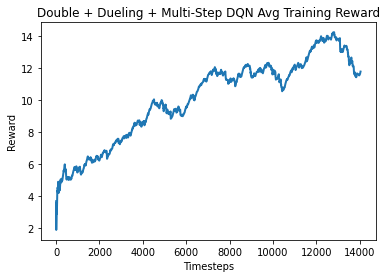

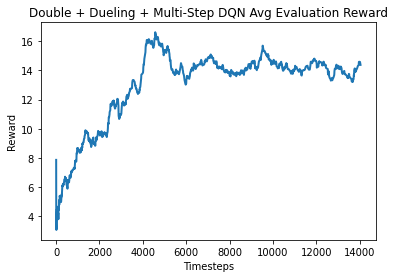

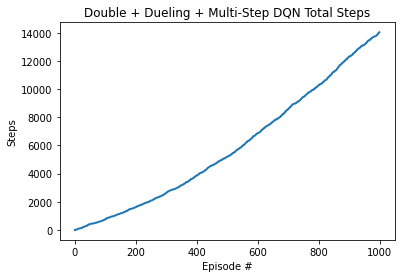

In [19]:
nfq_steps, nfq_r, nfq_score = result.T


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(nfq_steps, nfq_r, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Timesteps')
ax1.set_title('Double + Dueling + Multi-Step DQN Avg Training Reward')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(nfq_steps, nfq_score, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Timesteps')
ax2.set_title('Double + Dueling + Multi-Step DQN Avg Evaluation Reward')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(nfq_steps, linewidth=2)
plt.ylabel('Steps')
plt.xlabel('Episode #')
ax3.set_title('Double + Dueling + Multi-Step DQN Total Steps')


plt.show()



In [12]:
save_checkpoint(agent.qnetwork, 'Rainbow_dqn_network_1000_episodes', mode = 0)
export_to_local_drive('Rainbow_dqn_network_1000_episodes')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
data = result

# Save results
np.savetxt("Rainbow_dqn_1000_episodes_results.csv", data, delimiter=", ", fmt="% s")

In [17]:
files.download("Rainbow_dqn_1000_episodes_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Perform rollouts of trained agent 
env = gym.make('highway-v0')
num_rollouts = 5 
mean, std = agent.evaluate(env,num_rollouts)
print("Rollout for {:d} episode(s): {:.4f} +- {:.4f}".format(num_rollouts, mean, std))

Text(0.5, 0.98, 'DQN Variant Evaluation Performance')

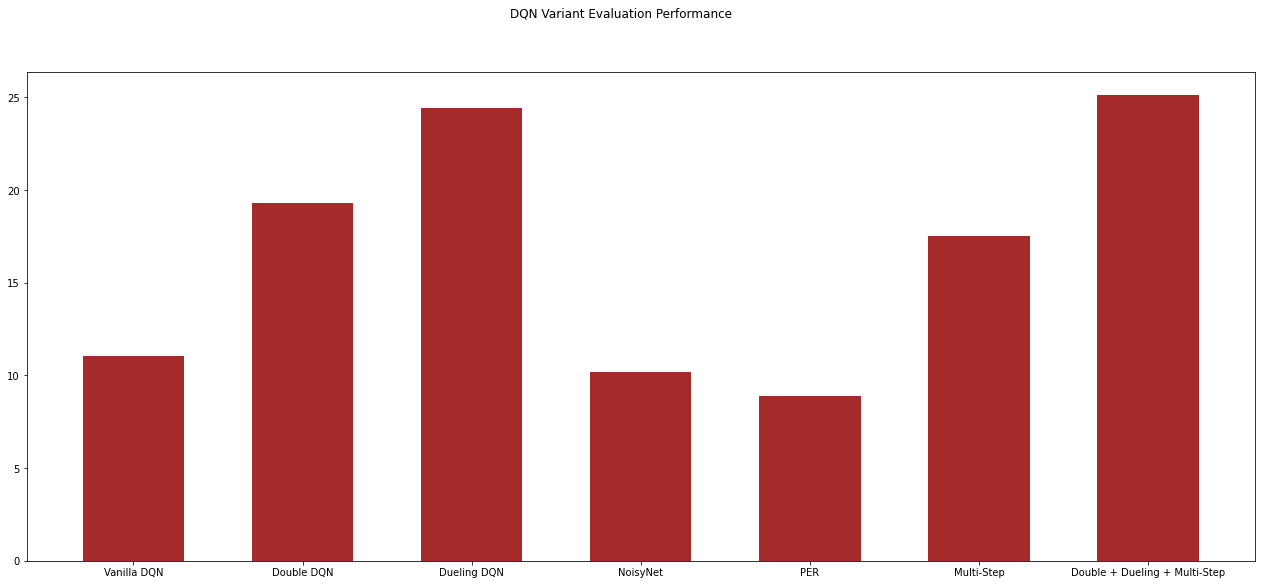

In [18]:
# Plot results of DQN variants 
data = {'Vanilla DQN': 11.0564, 'Double DQN': 19.3297, 'Dueling DQN': 24.4364, 'NoisyNet': 10.1840,
        'PER': 8.9022, 'Multi-Step': 17.5464, 
        'Double + Dueling + Multi-Step': 25.1386}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(22, 9), sharey=True)
axs.bar(names, values, width=.6, color = 'brown')
fig.suptitle('DQN Variant Evaluation Performance')

In [ ]:
display = Display(visible=0, size=(400, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

env = gym.make('highway-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
state = env.reset().flatten()
done = False
while not done:
    action = agent.greedy_action(state)
    state, reward, done, info = env.step(action)
    state = state.flatten()
env.close()
show_video('./video')